<a href="https://colab.research.google.com/github/ShuHuiK/WIE3007_Group_Assignment/blob/shuhui_2/Neural_Network_Model_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trial 30 Complete [00h 00m 05s]
val_auc: 0.7326186895370483

Best val_auc So Far: 0.7668803930282593
Total elapsed time: 00h 02m 04s

Retraining the best model...

Tuning classification threshold to maximize F1-Score...


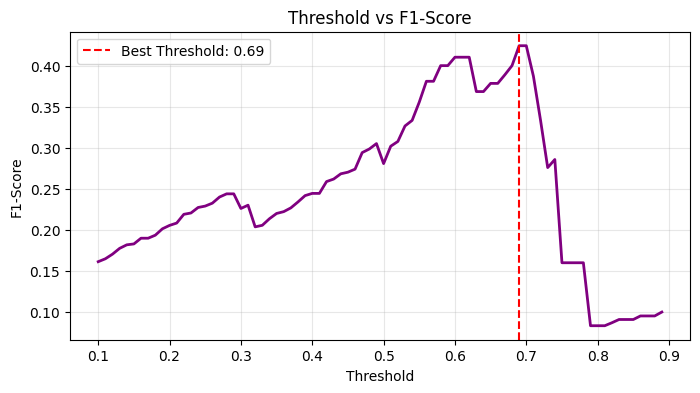


EVALUATION (Tuned Threshold: 0.69)
              precision    recall  f1-score   support

  No Default       0.96      0.97      0.97       282
     Default       0.47      0.39      0.42        18

    accuracy                           0.94       300
   macro avg       0.71      0.68      0.70       300
weighted avg       0.93      0.94      0.93       300

ROC AUC Score: 0.7872
F1 Score:      0.4242


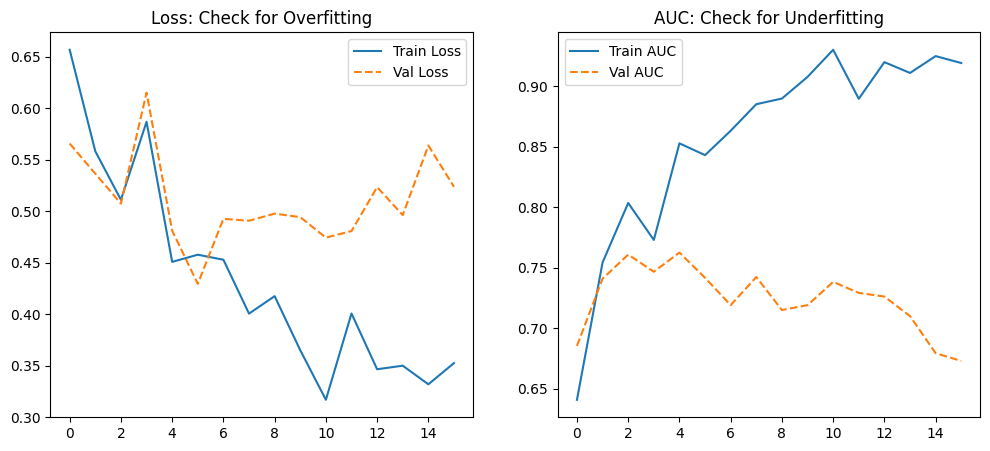


Calculating Feature Importance (Manual Permutation)...


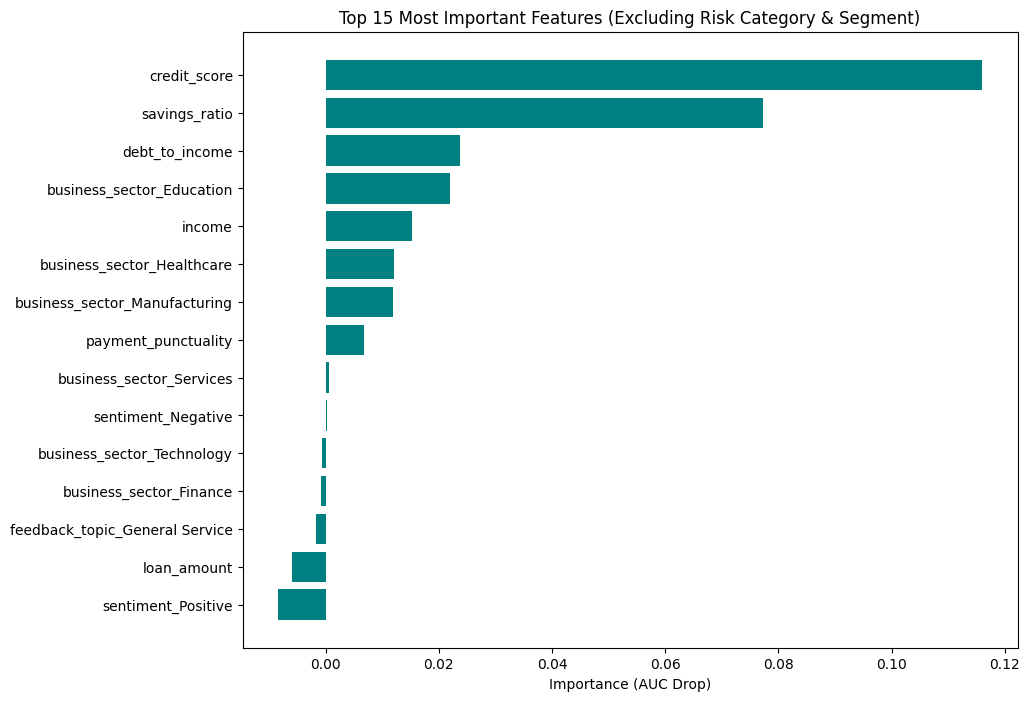

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve

# ==========================================
# 1. LOAD AND PREPROCESS DATA
# ==========================================
df = pd.read_csv('2025_Sterling_Financial_Dataset_clean.csv')

# UPDATED: Added 'risk_category' and 'customer_segment' to the drop list
drop_cols = ['date', 'customer_id', 'customer_feedback', 'location', 'risk_category', 'customer_segment']
X = df.drop(columns=['default_history'] + drop_cols)
y = df['default_history']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y.values, test_size=0.2, random_state=42, stratify=y
)

# 2. HANDLE CLASS IMBALANCE
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}

# ==========================================
# 3. DEFINE TUNABLE MODEL
# ==========================================
def model_builder(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.4, step=0.1)))

    model.add(layers.Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

# 4. RUN HYPERPARAMETER SEARCH

tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_auc", direction="max"),
    max_epochs=20,
    factor=3,
    directory='tuning_dir',
    project_name='sterling_final_project'
)

print("\nStarting Hyperparameter Search...")
stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2,
             class_weight=class_weights, callbacks=[stop_early], verbose=1)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# 5. FINAL TRAINING
print("\nRetraining the best model...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

# ==========================================
# 6. THRESHOLD TUNING
# ==========================================
print("\nTuning classification threshold to maximize F1-Score...")
y_probs = model.predict(X_test, verbose=0)
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, (y_probs > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]


plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, color='purple', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('Threshold vs F1-Score')
plt.xlabel('Threshold'); plt.ylabel('F1-Score'); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# ==========================================
# 7. FINAL EVALUATION
# ==========================================
y_pred_tuned = (y_probs > best_threshold).astype(int)

print("\n" + "="*30)
print(f"EVALUATION (Tuned Threshold: {best_threshold:.2f})")
print("="*30)
print(classification_report(y_test, y_pred_tuned, target_names=['No Default', 'Default']))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_probs):.4f}")
print(f"F1 Score:      {f1_score(y_test, y_pred_tuned):.4f}")

# 8. TRAINING CURVES
auc_key = [k for k in history.history.keys() if 'auc' in k.lower() and 'val' not in k.lower()][0]
val_auc_key = [k for k in history.history.keys() if 'auc' in k.lower() and 'val' in k.lower()][0]


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Loss: Check for Overfitting'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history[auc_key], label='Train AUC')
plt.plot(history.history[val_auc_key], label='Val AUC', linestyle='--')
plt.title('AUC: Check for Underfitting'); plt.legend()
plt.show()

# ==========================================
# 9. FEATURE IMPORTANCE (Manual Permutation)
# ==========================================
print("\nCalculating Feature Importance (Manual Permutation)...")
baseline_auc = roc_auc_score(y_test, y_probs)
importances = []
feature_names = preprocessor.get_feature_names_out()
clean_names = [name.split('__')[-1] for name in feature_names]

X_test_temp = X_test.copy()
for i in range(X_test.shape[1]):
    save_col = X_test_temp[:, i].copy()
    np.random.seed(42)
    np.random.shuffle(X_test_temp[:, i])
    y_perm_prob = model.predict(X_test_temp, verbose=0)
    importances.append(baseline_auc - roc_auc_score(y_test, y_perm_prob))
    X_test_temp[:, i] = save_col

importance_df = pd.DataFrame({'Feature': clean_names, 'Importance': importances}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][-15:], importance_df['Importance'][-15:], color='teal')
plt.title('Top 15 Most Important Features (Excluding Risk Category & Segment)')
plt.xlabel('Importance (AUC Drop)')
plt.show()